In [2]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import os
import torch

import stLVG_upload
from stLVG_upload.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from stLVG_upload.viz import match_3D_multi, hist, Sankey, build_3D
from stLVG_upload.metrics import region_statistics

In [3]:
adata_1=sc.read_h5ad("D:\ppppaper\data\seqFISH\seqFish_adata.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 14891 × 351
    obs: 'z', 'uniqueID', 'x_global', 'y_global', 'embryo', 'Estage', 'x_global_affine', 'y_global_affine', 'UMAP1', 'UMAP2', 'cluster', 'celltype_mapped_refined', 'celltype_mapped'
    var: 'gene_names'
    obsm: 'spatial'

In [4]:
adata_1.obs['celltype_mapped_refined']

embryo2_Pos29_cell10_z2     Forebrain/Midbrain/Hindbrain
embryo2_Pos29_cell10_z5     Forebrain/Midbrain/Hindbrain
embryo2_Pos29_cell100_z2    Forebrain/Midbrain/Hindbrain
embryo2_Pos29_cell100_z5    Forebrain/Midbrain/Hindbrain
embryo2_Pos29_cell101_z2                     Low quality
                                        ...             
embryo2_Pos50_cell97_z5                      Spinal cord
embryo2_Pos50_cell98_z2                      Spinal cord
embryo2_Pos50_cell98_z5                      Spinal cord
embryo2_Pos50_cell99_z2                      Spinal cord
embryo2_Pos50_cell99_z5                      Spinal cord
Name: celltype_mapped_refined, Length: 14891, dtype: category
Categories (24, object): ['Allantois', 'Anterior somitic tissues', 'Blood progenitors', 'Cardiomyocytes', ..., 'Sclerotome', 'Spinal cord', 'Splanchnic mesoderm', 'Surface ectoderm']

In [5]:
selected_celltypes = ['Allantois', 'Anterior somitic tissues', 'Blood progenitors', 'Cardiomyocytes', 'Cranial mesoderm', 'Definitive endoderm', 'Dermomyotome', 'Endothelium', 'Erythroid', 'ExE endoderm', 'Forebrain/Midbrain/Hindbrain',
                      'Haematoendothelial progenitors', 'Intermediate mesoderm', 'Lateral plate mesoderm', 'Mixed mesenchymal mesoderm', 'NMP', 'Neural crest', 'Presomitic mesoderm', 'Sclerotome', 'Splanchnic mesoderm', 'Surface ectoderm']
filtered_adata = adata_1[adata_1.obs['celltype_mapped_refined'].isin(selected_celltypes), :]
print(filtered_adata)
filtered_adata.write('./filtered_seqFish.h5ad')


View of AnnData object with n_obs × n_vars = 11529 × 351
    obs: 'z', 'uniqueID', 'x_global', 'y_global', 'embryo', 'Estage', 'x_global_affine', 'y_global_affine', 'UMAP1', 'UMAP2', 'cluster', 'celltype_mapped_refined', 'celltype_mapped'
    var: 'gene_names'
    obsm: 'spatial'


In [6]:
adata_2=sc.read_h5ad("D:\ppppaper\data\Stereo_seq\E9.5_E1S1.MOSTA.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 5913 × 25568
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Re

In [7]:
adata_2.obs['annotation']

cell_name
147_104        Cavity
147_105        Cavity
147_106        Cavity
147_107        Cavity
147_108    Mesenchyme
              ...    
253_110        Cavity
253_111        Cavity
253_112        Cavity
253_113        Cavity
253_114        Cavity
Name: annotation, Length: 5913, dtype: category
Categories (12, object): ['AGM', 'Brain', 'Branchial arch', 'Cavity', ..., 'Mesenchyme', 'Neural crest', 'Notochord', 'Sclerotome']

In [8]:
selected_celltypes = ['AGM', 'Brain', 'Branchial arch', 'Connective tissue', 'Dermomyotome', 'Heart', 'Liver', 'Mesenchyme', 'Neural crest', 'Notochord', 'Sclerotome']
filtered_adata = adata_2[adata_2.obs['annotation'].isin(selected_celltypes), :]
print(filtered_adata)
filtered_adata.write('./filtered_Stereoseq.h5ad')


View of AnnData object with n_obs × n_vars = 5031 × 25568
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clo

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

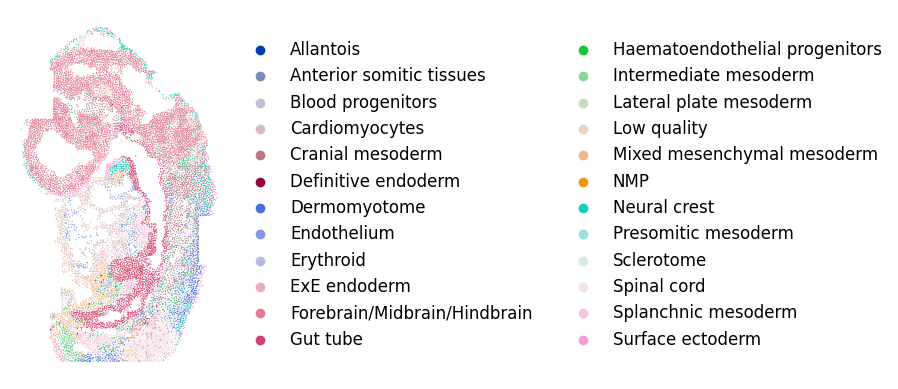

In [9]:
spot_size = 0.8
sc.pl.spatial(adata_1, img_key=None, color=['celltype_mapped_refined'], title=[''],
              legend_fontsize=12, show=False, frameon=False, spot_size=spot_size)

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

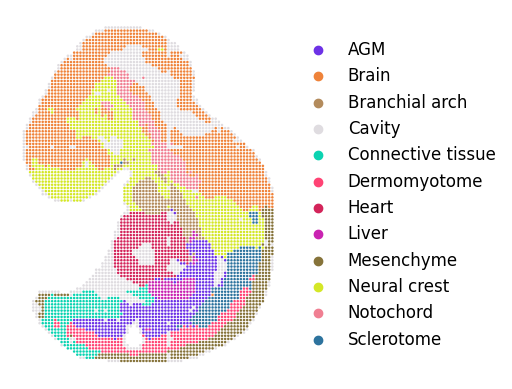

In [10]:
spot_size = 0.8
sc.pl.spatial(adata_2, img_key=None, color=['annotation'], title=[''],
              legend_fontsize=12, show=False, frameon=False, spot_size=spot_size)